In [72]:
import tempfile
from collections import Counter

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
from anndata import AnnData
# import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
# ignore warnings
import warnings
import pandas as pd
import numpy    as np
warnings.filterwarnings("ignore")
# limit show df size
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
np.set_printoptions(threshold=100) 
np.random.seed(0)



In [73]:
save_dir = 'data/totalVI'
# adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir)
adata = scvi.data.spleen_lymph_cite_seq(save_path=save_dir)
adata.obsm['protein_expression'].shape
adata


INFO     File data/totalVI/sln_111.h5ad already downloaded                                                         
INFO     File data/totalVI/sln_208.h5ad already downloaded                                                         


AnnData object with n_obs × n_vars = 30474 × 13553
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    obsm: 'isotypes_htos', 'protein_expression'

In [74]:
sc.read_10x_h5('/home/barroz/Downloads/10k_PBMCs_TotalSeq_B_3p_raw_feature_bc_matrix.h5')

AnnData object with n_obs × n_vars = 2421702 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [75]:
adata.obsm['protein_expression'].shape
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
adata_rna.obsm.pop('protein_expression')
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
adata_prot,     adata_rna

(AnnData object with n_obs × n_vars = 30474 × 110
     obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch',
 AnnData object with n_obs × n_vars = 30474 × 13553
     obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
     obsm: 'isotypes_htos')

In [76]:
adata_prot

AnnData object with n_obs × n_vars = 30474 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'

In [77]:
# plot protein expression pca and rna expression pca
# sc.pp.pca(adata_prot)
# sc.pp.pca(adata_rna)
# sc.pl.pca(adata_prot)
# sc.pl.pca(adata_rna)
# take a subset of the data using scanpy to a new anndata object


In [78]:
# Updated cell type mapping with all specified types
cell_type_mapping = {
    'Activated CD4 T': 'T cells',
    'B1 B': 'B cells',
    'CD122+ CD8 T': 'T cells',
    'CD4 T': 'T cells',
    'CD8 T': 'T cells',
    'Erythrocytes': 'Red blood cells',
    'GD T': 'T cells',
    'ICOS-high Tregs': 'Regulatory T cells',
    'Ifit3-high B': 'B cells',
    'Ifit3-high CD4 T': 'T cells',
    'Ifit3-high CD8 T': 'T cells',
    'Ly6-high mono': 'Monocytes',
    'Ly6-low mono': 'Monocytes',
    'MZ B': 'B cells',
    'MZ/Marco-high macrophages': 'Macrophages',
    'Mature B': 'B cells',
    'Migratory DCs': 'Dendritic cells',
    'NK': 'Natural killer cells',
    'NKT': 'Natural killer T cells',
    'Neutrophils': 'Neutrophils',
    'Plasma B': 'B cells',  # Added missing type
    'Red-pulp macrophages': 'Macrophages',
    'Transitional B': 'B cells',
    'Tregs': 'Regulatory T cells',
    'cDC1s': 'Conventional dendritic cells',
    'cDC2s': 'Conventional dendritic cells',
    'pDCs': 'Plasmacytoid dendritic cells'
}

# Map the specific cell types to major cell types and add as a new column in obs
adata_rna.obs['major_cell_types'] = pd.Categorical( adata_rna.obs['cell_types'].map(cell_type_mapping))
adata_prot.obs['major_cell_types'] =pd.Categorical(  adata_prot.obs['cell_types'].map(cell_type_mapping))
major_to_minor_dict ={}
# from major to     minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)
    
[len(x) for x in major_to_minor_dict.values()]

[7, 6, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1]

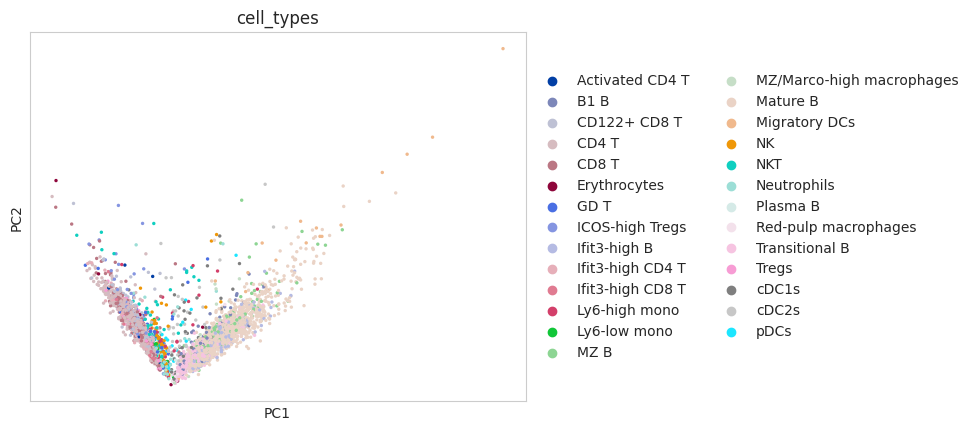

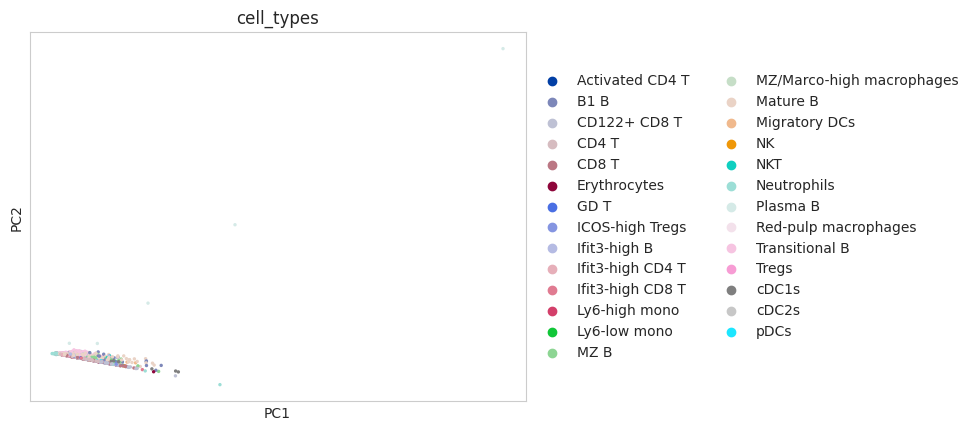

In [79]:
adata_prot_subset = sc.pp.subsample(adata_prot, n_obs=5000,copy=    True)
adata_rna_subset = sc.pp.subsample(adata_rna, n_obs=5000,copy=    True)
sc.pp.pca(adata_prot_subset)
sc.pp.pca(adata_rna_subset)
sc.pl.pca(adata_prot_subset,color='cell_types')
sc.pl.pca(adata_rna_subset,color='cell_types')


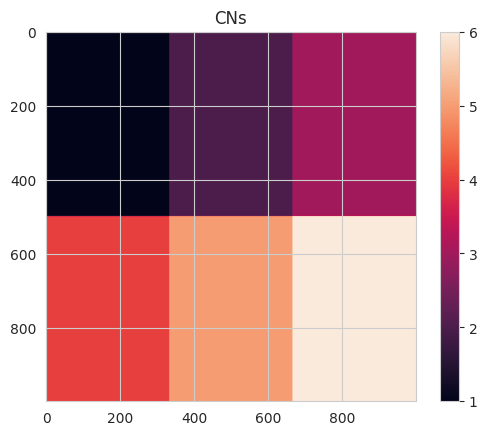

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Define the dimensions
horizontal_splits = [0, 500, 1000]
vertical_splits = [0, 333, 666, 1000]

# Define the regions using nested loops and product()
regions = [
    list(product(range(horizontal_splits[i], horizontal_splits[i + 1]),
                 range(vertical_splits[j], vertical_splits[j + 1])))
    for i in range(len(horizontal_splits) - 1)
    for j in range(len(vertical_splits) - 1)
]

# Create a blank board
board = np.zeros((1000, 1000))

# Assign different values to each region for visualization
for idx, region in enumerate(regions):
    # Convert each region's list of tuples to an array to index properly
    coords = np.array(region)
    board[coords[:, 0], coords[:, 1]] = idx + 1  # Assign different values for each region

# Visualize the board to confirm each region
plt.imshow(board)
plt.title('CNs')
plt.colorbar()
plt.show()


In [81]:
# set x and y coor for each cell in dataset and place it in the adata_prot_subset
adata_prot_subset.obs['X'] = np.random.randint(0, 1000, adata_prot_subset.n_obs)
adata_prot_subset.obs['Y'] = np.random.randint(0, 1000, adata_prot_subset.n_obs)

# map minor cell types of B cells to diffrene neighboring regions by samplesing from the regions
# and placing the cells in the regions
# make a minor cell type to region dict
minor_to_region_dict = {}
for i, cell_type in enumerate(major_to_minor_dict['B cells']):
    minor_to_region_dict[cell_type] = i

# Place the cells in the regions
for cell_type, region in minor_to_region_dict.items():
    # Get the indices of the cells of the current cell type
    cell_indices = adata_prot_subset.obs['cell_types'] == cell_type
    # Get the coordinates of the cells
    coords = np.array(regions[region])
    # Place the cells in the regions
    adata_prot_subset.obs['X'][cell_indices] = np.random.choice(coords[:, 0], sum(cell_indices))
    adata_prot_subset.obs['Y'][cell_indices] = np.random.choice(coords[:, 1], sum(cell_indices))
    
adata_prot_subset.obsm['X_spatial'] = np.array(adata_prot_subset.obs[['X', 'Y']])

In [82]:
adata_prot_subset

AnnData object with n_obs × n_vars = 5000 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'X', 'Y'
    uns: 'pca', 'cell_types_colors'
    obsm: 'X_pca', 'X_spatial'
    varm: 'PCs'

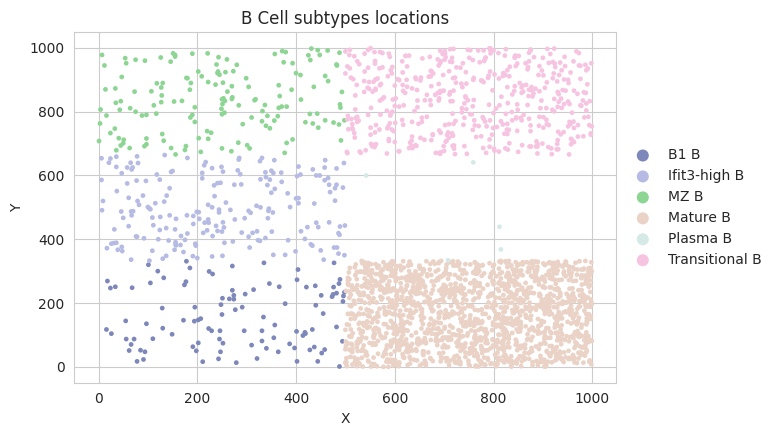

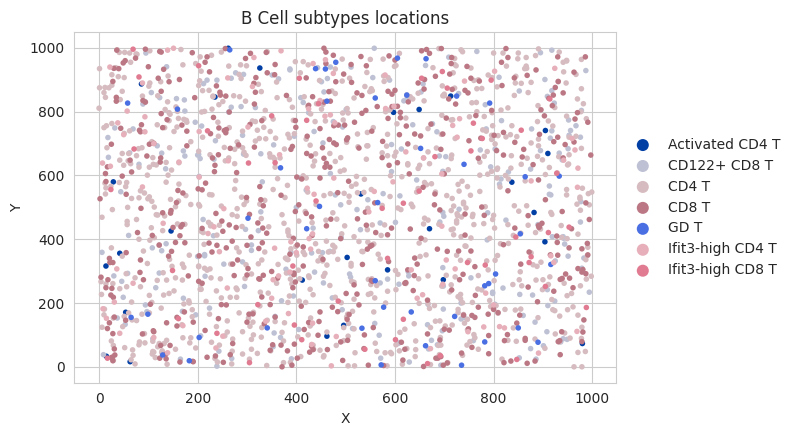

In [83]:
sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='T cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')


In [84]:
# get all unieq from connectivities sparse matrix

In [85]:
sc.pp.neighbors(adata_prot_subset,use_rep='X_spatial')
connectivities = adata_prot_subset.obsp['connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))


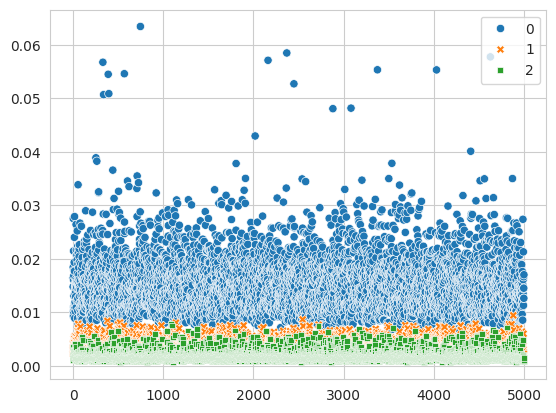

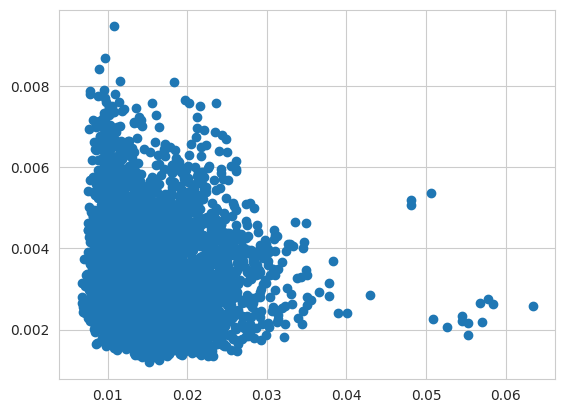

In [86]:
neighbor_sums = connectivities.dot(adata_prot_subset.X) # get the sum of all neighbors
# np.array(connectivities.todense()[connectivities.todense()!=0].flatten())
neighbor_means = neighbor_sums/neighbor_sums.sum(1)[:,np.newaxis] # normalize
sns.scatterplot(neighbor_means[:,:3])
plt.show()
plt.scatter(neighbor_means[:,0],neighbor_means[:,1])

